# My Tokenizer

In [1]:
import copy
import os
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import load_dataset


# import the right version of tqdm for where we are running
try:
    env_type = get_ipython().__class__.__name__
except NameError:
    env_type = 'terminal'
if env_type == 'ZMQInteractiveShell':
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm

if torch.cuda.is_available():
    torch.set_default_device('cuda')
# Force cpu because it's much faster than mps.
# I have no ide why, but such is life.
#elif torch.backends.mps.is_available():
#    torch.set_default_device('mps')
else:
    torch.set_default_device('cpu')

## Config and constants

In [2]:

vocab_file: str = "vocab.txt"  # path to output vocab file
overwrite: bool = True  # overwrite existing vocab file
max_vocab_size: int = 50_000  # maximum size of vocab
max_token_length: int = 40  # maximum length of token
random_seed = 42

#max_examples = 36_718
max_examples = 1_000

if not overwrite:
    assert not os.path.exists(vocab_file), f"{vocab_file} already exists"
assert max_vocab_size > 0, f"max_vocab_size must be positive, got {max_vocab_size}"
assert max_token_length > 0, f"max_token_length must be positive, got {max_token_length}"
max_entropy = float(np.log2(max_vocab_size))


## Load dataset to calculate token frequencies 

In [3]:

# ds_full = load_dataset("wikitext", "wikitext-2-raw-v1", split="train")
ds_full = load_dataset("graelo/wikipedia", "20230901.en", split="train")
dl_full = ds_full.to_iterable_dataset().shuffle(seed=random_seed, buffer_size=10_000)

ds = []
with tqdm(total=max_examples, desc="loading dataset", unit='example') as pb:
    for i, ex in enumerate(dl_full):
        if i >= max_examples:
            break
        ds.append(bytes(ex['text'], 'utf-8'))
        pb.update(1)
        pb.refresh()

assert len(ds) == max_examples, f"expected {max_examples} examples, got {len(ds)}"


loading dataset:   0%|          | 0/1000 [00:00<?, ?example/s]

## Helper functions

In [4]:
def normalize(c, dim=None):
    """Converts a Counter or dict to a probability distribution"""
    if isinstance(c, (dict, Counter)):
        total = sum(c.values())
        p = {k: v / total for k, v in c.items()}
    else:
        p = torch.tensor(c)
        p = p / p.sum(dim=dim, keepdim=True)
    return p
    
def entropy(c, dim=None, keepdim=False):
    """Computes the entropy of a Counter or dict"""
    p = normalize(c, dim=dim)
    if isinstance(c, (dict, Counter)):
        p = torch.tensor(list(p.values()))
    p = p[p > 0]
    return -torch.sum(p * torch.log2(p).nan_to_num(), dim=dim, keepdim=keepdim)

def make_inital_vocab(ds=ds):
    """Creates an initial vocab from a dataset"""
    c = Counter({bytes([i]):0 for i in range(256)})
    for example in tqdm(ds, desc=f"finding all 1-byte token frequencies", smoothing=0, unit="example", leave=True):
        for i in example:
            #assert isinstance(i, int) and i <256, f"expected 1-byte tokens, got {repr(i)}"
            c.update({bytes([i]): 1 })
            #c[bytes([i])] = c.get(bytes([i]), 0) + 1
    return c

def get_freqs(tokens, ds=ds, progress=False):
    """Finds the frequency of each token in tokens in the dataset ds"""
    #tqdm.write(f"finding frequency of {len(tokens)} tokens...")
    freqs = defaultdict(int)
    if progress:
        ds = tqdm(ds, total=len(ds), desc=f"finding frequency of {len(tokens)} tokens", smoothing=0, unit="example")
    for ex in ds:
        for t in tokens:
            freqs[t] += ex.count(t)
    return freqs

def find_best_merge(all_tokens, all_freqs, a_token, b_tokens, b_freqs, merge_tokens, merge_freqs):
    """Finds the best b_token to merge with a given a_token to maximize the entropy of the frequencies of the resulting token set"""
    all_freqs = torch.tensor(all_freqs) 
    merge_freqs = torch.tensor(merge_freqs)


    freqs_t = normalize(all_freqs).unsqueeze(0) * torch.ones(len(merge_freqs), len(all_freqs))
    freqs_t = torch.cat([freqs_t, merge_freqs.unsqueeze(1)], dim=1)
    assert freqs_t.shape == (len(merge_freqs), len(vocab)+1), f"{len(vocab)+1=}, {freqs_t.shape=}, {len(merge_freqs)=} {merge_freqs.unsqueeze(0).shape=}"
    at_idx = torch.tensor([all_tokens.index(a_token)])
    freqs_t[:, at_idx] = freqs_t[:, at_idx] - merge_freqs.unsqueeze(1)
    bt_idxes = torch.tensor([all_tokens.index(bt) for bt in b_tokens])
    freqs_t[:, bt_idxes] = freqs_t[:, bt_idxes] - merge_freqs.unsqueeze(1)
    #for m_idx, (bt, bf, mt, mf) in enumerate(zip(b_tokens, b_freqs, merge_tokens, merge_freqs)):
    #    bt_idx = all_tokens.index(bt)
    #    freqs_t[m_idx, bt_idx] -= float(mf)
    #    freqs_t[m_idx, at_idx] -= float(mf)
    freqs_t = normalize(freqs_t, dim=1)
    h = entropy(freqs_t, dim=-1)
    best_idx = int(torch.argmax(h))
    
    b_token = bytes(b_tokens[best_idx])
    b_freq = float(b_freqs[best_idx])
    merge_token = bytes(merge_tokens[best_idx])
    merge_ffreq = float(merge_freqs[best_idx])
    
    return (b_token, b_freq, merge_token, merge_ffreq)


## Initialize vocabulary with all 256 1-byte tokens

In [5]:
vocab = make_inital_vocab()

token_freqs_list = list(reversed(vocab.most_common()))
freqs = torch.tensor([x[1] for x in token_freqs_list])
x = torch.arange(len(freqs))
print(f"least common 1-byte tokens: {token_freqs_list[:10]}")
print(f"most common 1-byte tokens: {list(reversed(token_freqs_list[-10:]))}")
print(f"total 1-byte tokens: {len(vocab.values())}")
print(f"{max_vocab_size=:,}, {max_token_length=:,} number of 1-char tokens={len(vocab):,}", flush=True)

finding all 1-byte token frequencies:   0%|          | 0/1000 [00:00<?, ?example/s]

least common 1-byte tokens: [(b'\xff', 0), (b'\xfe', 0), (b'\xfd', 0), (b'\xfc', 0), (b'\xfb', 0), (b'\xfa', 0), (b'\xf9', 0), (b'\xf8', 0), (b'\xf7', 0), (b'\xf6', 0)]
most common 1-byte tokens: [(b' ', 1067530), (b'e', 616985), (b'a', 448929), (b't', 420940), (b'i', 391628), (b'n', 391320), (b'o', 377219), (b'r', 351940), (b's', 328884), (b'h', 226475)]
total 1-byte tokens: 256
max_vocab_size=50,000, max_token_length=40 number of 1-char tokens=256


## visualize distribution of token freqencies in initial vocabulary

/Users/alethea/miniconda3/envs/default/lib/python3.11/site-packages/torch/utils/_device.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


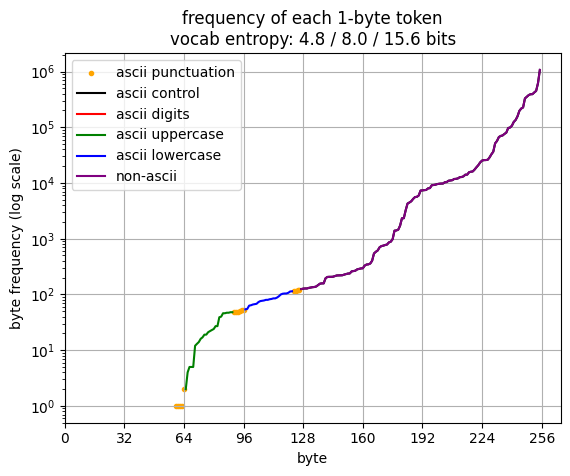

In [6]:
# ascii byte ranges
punct_idx = torch.tensor(list(range(32,48)) + list(range(58,65)) + list(range(91,97)) + list(range(123,127)))
digit_idx = torch.tensor(list(range(48,58)))
lower_idx = torch.tensor(list(range(97,123)))
upper_idx = torch.tensor(list(range(65,91)))
control_idx = torch.tensor(list(range(0,32)))
other_idx = torch.tensor(list(range(127,256)))

# plot frequencies
plt.scatter(x[punct_idx].tolist(), freqs[punct_idx].tolist(), marker='.', color='orange', label='ascii punctuation')
plt.plot(x[other_idx].tolist(), freqs[other_idx].tolist(), color='black', label='ascii control')
plt.plot(x[digit_idx].tolist(), freqs[digit_idx].tolist(), color='red', label='ascii digits')
plt.plot(x[upper_idx].tolist(), freqs[upper_idx].tolist(), color='green', label='ascii uppercase')
plt.plot(x[lower_idx].tolist(), freqs[lower_idx].tolist(), color='blue', label='ascii lowercase')
plt.plot(x[other_idx].tolist(), freqs[other_idx].tolist(), color='purple', label='non-ascii')
plt.yscale('log')
plt.title(f'frequency of each 1-byte token\nvocab entropy: {entropy(freqs):.1f} / {np.log2(256):.1f} / {max_entropy:.1f} bits')
plt.xlabel('byte')
plt.ylabel('byte frequency (log scale)')
plt.xticks(list(range(0, 257, 32))) #, rotation=90, labels=xtick_labels)
plt.grid()
plt.legend()
if env_type == 'ZMQInteractiveShell':
    plt.show()
else:
    plt.savefig('1-byte-token-frequencies.png', dpi=300)
    plt.close()

## Merge to increase entropy of the vocabulary

In [7]:
raw_freqs_cache = {t: f for t, f in vocab.items()}

raw_freqs_cache.update(get_freqs([t1+t2 for t1 in vocab for t2 in vocab], progress=True)) 

finding frequency of 65536 tokens:   0%|          | 0/1000 [00:00<?, ?example/s]

In [8]:
def desc(f, max_h=max_entropy):
    return f"entropy: (h={entropy(f):.02f}/{np.log2(len(f)):.02f}/{max_h:.02f} bits) "

x_time = []
y_freqs = []


with tqdm(desc=f"tokens: {vocab.most_common(3)=} ", total=max_vocab_size, initial=len(vocab), unit="token", position=0, leave=True) as tokens_pb:
    with tqdm(desc=desc(vocab), total=round(max_entropy, 2), initial=round(float(entropy(vocab)), 2), unit="bit", smoothing=1, position=1, leave=True) as entropy_pb:
        while len(vocab) < max_vocab_size:
            x_time.append(time.time())
            y_freqs.append(list(vocab.values()))
            median_freq = vocab.most_common()[len(vocab)//2][1]
            mergable_tokens_freqs = [(t,f) for t,f in vocab.most_common() if f >= 2]
            mergable_tokens, mergable_freqs = list(zip(*mergable_tokens_freqs))
            new_merged_tokens = [t1 + t2 for t1 in mergable_tokens for t2 in mergable_tokens if t1+t2 not in raw_freqs_cache]
            raw_freqs_cache.update(get_freqs(new_merged_tokens))

            no_mergable_tokens = True
            for at, af in mergable_tokens_freqs:
                af = int(af)
                rtfmtf = [(bt, bf, at+bt, raw_freqs_cache[at+bt]) for bt, bf in mergable_tokens_freqs if (at + bt not in vocab)]
                ltfmtf = [(bt, bf, bt+at, raw_freqs_cache[bt+at]) for bt, bf in mergable_tokens_freqs if (bt + at not in vocab)]

                btfmtf = rtfmtf + ltfmtf        
                btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if mf < af] #.87*af]
                btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if mf < bf] #.87*bf]
                btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if mf > 0] #.87*bf]
                btfmtf = [(bt, bf, mt, mf) for bt, bf, mt, mf in btfmtf if len(mt) <= max_token_length]

                if btfmtf:
                    all_tokens, all_freqs = list(zip(*vocab.most_common()))
                    (bt, bf, mt, mf) = find_best_merge(all_tokens, all_freqs, at, *zip(*btfmtf))
                    no_mergable_tokens = False
                    break
                    
            if no_mergable_tokens:
                print("no mergable tokens")
                break

            vocab[mt] = int(mf)
            vocab[at] -= int(mf)
            vocab[bt] -= int(mf)
            for t, f in reversed(vocab.most_common()):
                if (f <= 0) and (len(t) > 1):
                    del vocab[t]
                else:
                    break
            tokens_pb.n = len(vocab)
            tokens_pb.desc = f"tokens: {vocab.most_common(3)=} "
            entropy_pb.desc = f"entropy: (best possible: {round(np.log2(len(vocab)), 2)})"
            entropy_pb.n = round(float(entropy(vocab)), 1)
            tokens_pb.refresh()
            entropy_pb.refresh()
            x_time.append(time.time())
            y_freqs.append(list(vocab.values()))
            #pb.desc = desc(vocab)

x_time.append(time.time())
y_freqs.append(list(vocab.values()))


tokens: vocab.most_common(3)=[(b' ', 1067530), (b'e', 616985), (b'a', 448929)] :   1%|          | 256/50000 [0…

entropy: (h=4.76/8.00/15.61 bits) :  30%|###       | 4.76/15.61 [00:00<?, ?bit/s]

## visualize the vocabulary development

In [ ]:
# https://stackoverflow.com/questions/9401658/how-to-animate-a-scatter-plot
import matplotlib.animation as animation


class Animated(object):
    def __init__(self, x_time, y_freqs, frame_rate):
        self.x_time, self.y_freqs = x_time, y_freqs
        self.stream = self.data_stream()
        self.frame_rate = frame_rate
        self.ymin = 1
        self.ymax = max([int(f) for f in self.y_freqs[0]])

        # Setup the figure and axes...
        self.fig, self.ax = plt.subplots()
        # Then setup FuncAnimation.
        self.ani = animation.FuncAnimation(self.fig, self.update, interval=5, 
                                          save_count=len(self.x_time), blit=True) # init_func=self.update, 

    def data_stream(self):
        for t_raw, y_raw in tqdm(zip(self.x_time, self.y_freqs), total=len(self.x_time), desc="generating data stream", unit="frame", leave=True):
            t = time.strftime('%Y-%m-%d @ %I:%M:%S %Z', time.gmtime(t_raw)) # + str(t_raw % 60)
            y = sorted(y_raw)
            x = np.arange(len(y))
            yield (t, x, y)

    def update(self, i=0):
        try:
            t, x, y = next(self.stream)
        except StopIteration:
            return []
        for line in self.ax.lines:
            line.remove()
        self.plot = self.ax.plot(x, y, color='black')
        self.ax.set_title(f"{t}\nentropy: {entropy(y):.01f} / {np.log2(len(y)):.01f} / {max_entropy:.01f} bits , {len(y)} tokens")
        self.ax.set_ylabel('num occurences')
        self.ax.set_xlabel('token id')
        self.ax.set_yscale('log')
        #self.ax.set_xscale('log')
        #self.ax.set_ylim(0, max(y))
        self.ax.set_xlim(0, max_vocab_size)
        self.ax.set_ylim(self.ymin, self.ymax)
        #plt.show()
        return self.plot


framerate = 120
a = Animated(x_time[:120], y_freqs[:120], framerate)
plt.show()
a.ani.save('test.mp4', fps=120, extra_args=['-vcodec', 'libx264'])
#a.ani.save('test.gif', fps=30)


## beyond here is junk and experiments

## Ideas

In [ ]:
# allow freq 0 chars, but delete any char with freq 0 of length > 1
#   fix stop_tokens - right now I think it cuts too many things out - specfically, I'm wondering if we should just build the raw counters without splitting on stop tokens at all. 
#                     we should keep the cannot_split_tokens though. If we drop that, then we mibht end up stuck in an infinite loop. 
# switch from chars to bytes

# try making the original counter a of single char tokens, 
# then look at the most common token 


## analysis of the results

In [ ]:
#F_L = [(vocab[t], len(t)) for t in vocab]
#freqs, lens = list(zip(*sorted(F_L, reverse=True)))

L_F = [(len(t), vocab[t]) for t in vocab]
lens, freqs = list(zip(*sorted(L_F, reverse=True)))

lens = np.array(lens)
#lens = lens / lens.sum()
freqs = np.array(freqs)
#freqs = freqs / freqs.sum()
x = np.arange(len(lens))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x, lens, label="token length")
axes[0].set_title("token length")
axes[1].plot(x, freqs, label="token frequency")
axes[1].set_title("token frequency")
axes[1].set_yscale('log')
#plt.hist(lens, bins=range(1, max(lens) + 2))
plt.show()

In [ ]:
for t, f in vocab.most_common():
    print(f"{repr(t)} : {f:,}")

In [ ]:
freqs = sorted(freqs)
xticks = []
xtick_labels = []
idx = 0
prev_idx = 0
for freq in range(6):
    xticks.append(idx)
    xtick_labels.append(f"{idx:04} : {freqs[idx]:,}")
    idx = len([f for f in vocab.values() if f == freq]) + idx
idx = len(freqs) - 1
xticks.append(idx)
xtick_labels.append(f"{idx:04} : {freqs[idx]:,}")


plt.plot(x, freqs)
plt.yscale('log')
plt.title('frequency of each 1-char token')
plt.xlabel('1-token id (linear scale) : token frequency')
plt.ylabel('token frequency (log scale)')
plt.xticks(xticks, rotation=90, labels=xtick_labels)
plt.grid()
plt.show()